In [1]:
from pyMouSh import MoulinShape, TimeStamps, Qin_constant, Qin_sinusoidal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch

from collections import defaultdict
#import pandas as pd
import pickle
import seaborn as sns

sns.set_theme(style="ticks", font_scale=1.25)

secinday = 24*3600

# Calculate arrays for ploting

In [2]:

#temperature profile based of foxx data -- Lauren
tmp = pd.read_csv('Field_Data/temperature_foxx1.csv')
temperature_profile = tmp.temperature.to_numpy()#np.array([ZERO_KELVIN, ZERO_KELVIN])

initial_subglacial_area = 1 
regional_surface_slope = 0.01
channel_length = 25e3
ice_thickness = 500
initial_head = ice_thickness


time_start = 0
time_end = time_start + 20*secinday #55
timestep = 30*60 #seconds #timestep is longer to reduce the volume of data
time = TimeStamps(time_start,time_end,timestep)

# how many days to account for the calculation of the min and max of head
idx_nday = -2*48 #days*number of half an hour in a day

from numpy.random import default_rng
expected_head_amplitude = 50 # or 55 based of visual measurements of the head amplitude in JEME data
original_head_amplitude = 532.44 



### Sensitivity to meltwater input variability

In [3]:
n_run_sim1 = 200 # <------
# create random numbers 
rng1 = default_rng()
rgn2 = default_rng() 
Qin_mean_run = 1 * rng1.random(n_run_sim1) # <------
Qin_amplitude_run = rgn2.random(n_run_sim1) # <------


#initialize variables for loop:
head_amp_sim1 = []#np.zeros(n_run_Qin)
meltwater_input_sim1 = []
Qin_amp_sim1 = []
Qin_mean_sim1 = []

for idx_run in np.arange(n_run_sim1):   
    meltwater_input_sim1 = Qin_sinusoidal(time, Qin_mean_run[idx_run], Qin_amplitude_run[idx_run])         
    moulin = MoulinShape(ice_thickness = ice_thickness,
                        initial_head = initial_head,
                        initial_subglacial_area = initial_subglacial_area, 
                        channel_length = channel_length,
                        regional_surface_slope = regional_surface_slope,
                        temperature_profile = temperature_profile)
    
    #only take values of amplitude smaller or equal to the mean
    if Qin_mean_run[idx_run]>=2*Qin_amplitude_run[idx_run]:    
               
        for idx,t in enumerate(time) :
            moulin.run1step(time,
                            timestep,
                            meltwater_input_sim1[idx],
                            overflow = True,
                            subglacial_baseflow = 0) 
            
        ##save array for timeseries plot
        #meltwater_input.append(melt_in)   
        #head.append(moulin.dict['head'])
        
        #extract last days for calculating the mean and max
        head_portion = moulin.dict['head'][idx_nday:-1]
        #calculate head amplitude
        head_amp_sim1.append(np.max(head_portion) - np.min(head_portion)) #m
        #save variable for plot (so that all have the same index)
        Qin_amp_sim1.append(Qin_amplitude_run[idx_run])
        Qin_mean_sim1.append(Qin_mean_run[idx_run])


C:\Users\celia\GitHub\pyMouSh\pyMouSh.py:1625: RuntimeWarning: invalid value encountered in sqrt
  dhdt = 1/moulin_area_at_head * (Qin_compensated - C3*subglacial_area**(5/4)*np.sqrt((WATER_DENSITY*GRAVITY*head)/channel_length))
C:\Users\celia\GitHub\pyMouSh\pyMouSh.py:1627: RuntimeWarning: invalid value encountered in double_scalars
  melt = SUBGLACIAL_MELT_OPENING * C3 * subglacial_area**(5/4) * ((WATER_DENSITY*GRAVITY*head)/channel_length)**(3/2)
C:\Users\celia\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1350: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
C:\Users\celia\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1350: UserWarning: lsoda: Illegal input detected (internal error).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
C:\Users\celia\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1350: UserWarning: lsoda: Unexpected istate=-8
  warnings.warn('{:s}: {:s}'.form

### Sensitivity to mean baseflow

In [4]:
n_run_bf = 20

bf_mean_sim2      = np.linspace(0,5,n_run_bf) 
bf_amplitude_sim2 = 0 

#initialize variables for loop:
head_amp_sim2 = []
head = []

Qin_mean_sim2 = 0.3
Qin_amplitude_sim2 = 0.1
meltwater_input = Qin_sinusoidal(time, Qin_mean_sim2, Qin_amplitude_sim2)

for idx_run in np.arange(n_run_bf):        
    baseflow_sim2 = Qin_sinusoidal(time, bf_mean_sim2[idx_run], bf_amplitude_sim2) #mean,amplitude
    moulin = MoulinShape(ice_thickness = ice_thickness,
                          initial_head = initial_head,
                          initial_subglacial_area = initial_subglacial_area, 
                          channel_length = channel_length,
                          regional_surface_slope = regional_surface_slope,
                          temperature_profile = temperature_profile)
        
    for idx,t in enumerate(time) :
        moulin.run1step(time,
                        timestep,
                        meltwater_input[idx],
                        overflow = True,
                        subglacial_baseflow = baseflow_sim2[idx])         
    head.append(moulin.dict['head'])
    head_portion = moulin.dict['head'][idx_nday:-1]
    #calculate head amplitude
    head_amp_sim2.append(np.max(head_portion) - np.min(head_portion)) #m


# Sensitivity to lags

In [5]:
lags = np.arange(13)
Qin_mean_sim3 = 0.3
Qin_amplitude_sim3 = 0.1
meltwater_input_sim3 = Qin_sinusoidal(time, Qin_mean_sim3, Qin_amplitude_sim3)

bf_mean_sim3      = 0.1 ,0.3, 0.6,   1, 
bf_amplitude_sim3 = 0.1, 0.1, 0.1, 0.1, 

#initialize
head_amplitude = np.zeros(len(lags))
head_amp_lag = np.zeros([len(bf_mean_sim3),len(lags)]) #row,column

for idx_run in np.arange(len(bf_mean_sim3)):
    
    for idx_lag,lag in enumerate(lags):
        baseflow_sim3 = Qin_sinusoidal(time, bf_mean_sim3[idx_run], bf_amplitude_sim3[idx_run],shift=lag*3600) #mean,amplitude
        moulin = MoulinShape(ice_thickness = ice_thickness,
                              initial_head = initial_head,
                              initial_subglacial_area = initial_subglacial_area, 
                              channel_length = channel_length,
                              regional_surface_slope = regional_surface_slope,
                              temperature_profile = temperature_profile)
            
        for idx,t in enumerate(time) :
            moulin.run1step(time,
                            timestep,
                            meltwater_input_sim3[idx],
                            overflow = True,
                            subglacial_baseflow = baseflow_sim3[idx])         
        head_portion = moulin.dict['head'][idx_nday:-1]
        head_amplitude[idx_lag] = np.max(head_portion) - np.min(head_portion)#m
    head_amp_lag[idx_run] = head_amplitude
        



In [6]:
head_lag = np.zeros([len(lags),len(time)])
bf_lag = np.zeros([len(lags),len(time)])

bf_mean      = 1
bf_amplitude = 0.1
palette_lag = sns.color_palette('PuOr', n_colors=len(lags))

for idx_lag,lag in enumerate(lags):
    bf_lag[idx_lag] = Qin_sinusoidal(time, bf_mean, bf_amplitude,shift=lag*3600) #mean,amplitude
    moulin = MoulinShape(ice_thickness = ice_thickness,
                          initial_head = initial_head,
                          initial_subglacial_area = initial_subglacial_area, 
                          channel_length = channel_length,
                          regional_surface_slope = regional_surface_slope,
                        temperature_profile = temperature_profile)
        
    for idx,t in enumerate(time) :
        moulin.run1step(time,
                        timestep,
                        meltwater_input[idx],
                        overflow = True,
                        subglacial_baseflow = bf_lag[idx_lag,idx])         
    # head.append(moulin.dict['head'])
    head_lag[idx_lag] = moulin.dict['head']


# Plot

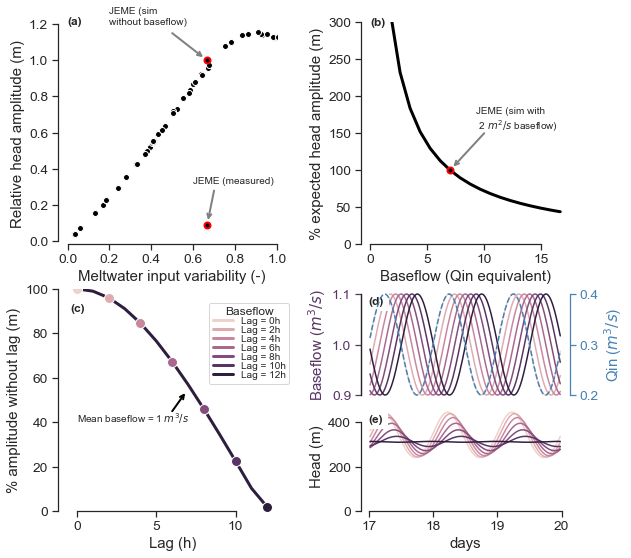

In [39]:

fig = plt.figure(figsize=(9,9))
outer = gridspec.GridSpec(2, 2,wspace=0.4) 
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[2])
gs4 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[3],hspace=0)#, wspace = 0.5)

ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs2[0,0])
ax3 = plt.subplot(gs3[0,0]) 
ax4 = plt.subplot(gs4[0,0])
ax4bis = ax4.twinx()
ax5 = plt.subplot(gs4[1,0])

#Sensitivity to meltwater input
#multiply Qin_amp_sim1 by 2
ax1.plot((np.array(Qin_amp_sim1))*2/np.array(Qin_mean_sim1),(np.array(head_amp_sim1)/original_head_amplitude),
         linestyle='',marker='o',markeredgecolor='white', color='black')
ax1.plot(0.2/0.3,1,marker='o',markeredgewidth=2,markeredgecolor='red', color='black')
ax1.plot(0.2/0.3,0.09,marker='o',markeredgewidth=2,markeredgecolor='red', color='black')
ax1.set_xlim([0,1])
ax1.set_ylabel('Relative head amplitude (m)')
ax1.set_xlabel('Meltwater input variability (-)')#('bf_amplitude/bf_mean')
sns.despine(offset=[10,0],trim=True, ax=ax1)

#Sensitivity to meltwater input
ax2.plot(np.array(bf_mean_sim2)/np.array(Qin_mean_sim2),
        (np.array(head_amp_sim2)/expected_head_amplitude)*100, 
         linestyle='-',marker='', linewidth=3, color='black', label='expected')
ax2.plot(2.1/0.3,100,marker='o', markeredgewidth=2,markeredgecolor='red', color='black')
ax2.set_ylabel('% expected head amplitude (m)')
ax2.set_xlabel('Baseflow (Qin equivalent)')#('bf_amplitude/bf_mean')
ax2.set_ylim([0,300])
#ax.legend()
sns.despine(offset=[0,0],trim=True, ax=ax2)



palette_lag = sns.cubehelix_palette(n_colors=len(head_lag[:,0]))

#Lag -- per baseflow

#ax3.plot(lags,(head_amp_lag[0,:]/head_amp_lag[0,0])*100,linestyle='-', linewidth=1, color='darkgrey')  
#ax3.plot(lags,(head_amp_lag[1,:]/head_amp_lag[1,0])*100,linestyle='-', linewidth=1, color='darkgrey')  
#ax3.plot(lags,(head_amp_lag[2,:]/head_amp_lag[2,0])*100,linestyle='-', linewidth=1, color='darkgrey')  
 
ax3.plot(lags,(head_amp_lag[3,:]/head_amp_lag[3,0])*100,linestyle='-', linewidth=3,
               label='mean = %s $m^3/s$'%bf_mean_sim3[3], 
               color=palette_lag[-1])          
ax3.set_ylim([0,100])
#ax3.set_xlim([0,14])
sns.despine(offset=[10,0],trim=True, ax=ax3)
ax3.set_ylabel('% amplitude without lag (m)')
ax3.set_xlabel('Lag (h)')
ax3.legend(loc=3, prop={'size': 10})

#plots dots
for idx in np.arange(0,len(lags),2):
    ax3.plot(lags[idx],(head_amp_lag[3,idx]/head_amp_lag[3,0])*100,
             linestyle='',marker='o',markeredgecolor='white', markersize=10, color=palette_lag[idx])


#Lag -- timeseries for one baselfow mean
ndays=3*48
color_melt = 'steelblue'
ax4bis.plot(time[-ndays:-1]/secinday, meltwater_input_sim3[-ndays:-1], label='Meltwater input', 
            linestyle='--',color=color_melt)
for idx in np.arange(0,len(head_lag[:,0]),2):
    ax4.plot(time[-ndays:-1]/secinday, bf_lag[idx][-ndays:-1], color=palette_lag[idx])
    ax5.plot(time[-ndays:-1]/secinday, head_lag[idx][-ndays:-1], color=palette_lag[idx])

ax4.set_ylabel('Baseflow ($m^3/s$)',color=palette_lag[-3])
ax4bis.set_ylabel('Qin ($m^3/s$)',color=color_melt)
#ax4.set_ylim([0.2,1.3])
ax4.tick_params(bottom=False, labelbottom=False, color=palette_lag[-3], labelcolor=palette_lag[-3])  
ax4bis.tick_params(bottom=False, labelbottom=False, color=color_melt, labelcolor=color_melt)
ax4.spines['left'].set_color(palette_lag[-3])
ax4bis.spines['right'].set_color(color_melt)


sns.despine(offset=[0,0],trim=True, ax=ax4, bottom=True)
sns.despine(offset=[0,0],trim=True, ax=ax4bis, bottom=True, right=False)#, right=False, left=True)
    
ax5.set_ylim([0,ice_thickness])
ax5.set_ylabel('Head (m)')
ax5.set_xlabel('days')
sns.despine(offset=[0,0],trim=True, ax=ax5)


elements = [Line2D([0], [0], color=palette_lag[0], lw=3, label='Lag = 0h'),
            Line2D([0], [0], color=palette_lag[2], lw=3, label='Lag = 2h'),
            Line2D([0], [0], color=palette_lag[4], lw=3, label='Lag = 4h'),
            Line2D([0], [0], color=palette_lag[6], lw=3, label='Lag = 6h'),
            Line2D([0], [0], color=palette_lag[8], lw=3, label='Lag = 8h'),
            Line2D([0], [0], color=palette_lag[10], lw=3, label='Lag = 10h'),
            Line2D([0], [0], color=palette_lag[12], lw=3, label='Lag = 12h')]

#ax4bis.legend(prop={'size': 10}, loc='center left', bbox_to_anchor=(0, 0.35))
ax3.legend(handles=elements, loc=3, bbox_to_anchor=(0.65, 0.55), labelspacing=0,  
           prop={'size': 10}, title='Baseflow',title_fontsize=12)

ax1.add_artist(ConnectionPatch((0.5,1.15),(0.2/0.3,1),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax1.text(0.2,1.2,'JEME (sim \nwithout baseflow)',fontsize=10)

ax1.add_artist(ConnectionPatch((0.7,0.28),(0.2/0.3,0.09),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax1.text(0.6,0.32,'JEME (measured)',fontsize=10)

ax2.add_artist(ConnectionPatch((10,150),(2.1/0.3,100),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax2.text(9.3,155,'JEME (sim with \n 2 $m^2/s$ baseflow)',fontsize=10)

ax3.add_artist(ConnectionPatch((6,45),(7,55),'data','data', shrinkB=5,
                arrowstyle="->", color='black', linewidth=2))
ax3.text(0,40,'Mean baseflow = 1 $m^3/s$',fontsize=10)

#letters
ax1.text(0,1.2,'(a)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))
ax2.text(0,295,'(b)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))
ax3.text(-0.4,90,'(c)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))
ax4.text(17,1.08,'(d)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))
ax5.text(17,400,'(e)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))


plt.savefig('Figure_TC/fig06.pdf')